<a href="https://colab.research.google.com/github/Rahul-sg123/Tamil_Abusive_Classifier/blob/main/Tamil_Abusive_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets sentencepiece accelerate


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification

mlm_model_name = "ai4bharat/IndicBERTv2-MLM-only"
cls_model_name = "ai4bharat/IndicBERTv2-CLS"

tokenizer = AutoTokenizer.from_pretrained(mlm_model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.75M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
from datasets import Dataset

unlabeled_df = pd.read_csv("/content/TestV2 - testV2.csv")

# Rename column for convenience (modify if your column name differs)
unlabeled_df = unlabeled_df.rename(columns={"Text": "text"})

# Convert to HF Dataset
unlabeled_dataset = Dataset.from_pandas(unlabeled_df)
unlabeled_dataset


Dataset({
    features: ['text'],
    num_rows: 913
})

In [ ]:
def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

tokenized_unlabeled = unlabeled_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling

mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
)


In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForMaskedLM

mlm_model = AutoModelForMaskedLM.from_pretrained(mlm_model_name)

mlm_training_args = TrainingArguments(
    output_dir="/content/mlm_finetuned",
    eval_strategy="no",              # FIXED
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=5000,
    logging_steps=500,
    weight_decay=0.01,
)

mlm_trainer = Trainer(
    model=mlm_model,
    args=mlm_training_args,
    train_dataset=tokenized_unlabeled,
    data_collator=mlm_collator,
)

mlm_trainer.train()
mlm_trainer.save_model("/content/mlm_tamil_adapted")


pytorch_model.bin:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/204 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie bert.embeddings.word_embeddings.weight to cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie cls.predictions.bias to cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BertForMaskedLM LOAD REPORT from: ai4bharat/IndicBERTv2-MLM-only
Key                          | Status     |  | 
-----------------------------+------------+--+-
cls.seq_relationship.weight  | UNEXPECTED |  | 
cls.seq_relationship.bias    | UNEXPECTED |  | 
bert.pooler.dense.bias       | UNEXPECTED |  | 
bert.pooler.dense.weight     | UNEXPECTED |  | 
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ig

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Step,Training Loss


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Re RUn from below step7

In [ ]:
import pandas as pd
from datasets import Dataset

# Load CSV
labeled_df = pd.read_csv("/content/trainV2.csv")

# Rename columns
labeled_df = labeled_df.rename(columns={"Text": "text", "Class": "label"})

# Normalize text labels
labeled_df["label"] = labeled_df["label"].astype(str).str.strip()

# Mapping based on your actual labels
label_map = {
    "Non-Abusive": 0,
    "Abusive": 1,
    "abusive": 1
}

# Apply mapping
labeled_df["label"] = labeled_df["label"].map(label_map)

# Check if any label failed to map (should be empty)
print("Unmapped labels:", labeled_df[labeled_df["label"].isna()]["label"].unique())

# Convert to integer
labeled_df["label"] = labeled_df["label"].astype(int)

print(labeled_df.head())
print(labeled_df.dtypes)


Unmapped labels: []
                                                text  label
0  நான் கூட உன்னை வெகுளியான பொண்ணு&#39;னு நெனச்சி...      0
1  உன் போட்டோவை டாய்லெட்டுக்கு மாற்றினார்கள் அசிங...      1
2  கண்டா வரச்சொல்லுங்க கார்த்திய திவ்யாவோட சேர்த்...      0
3  ஒன்னோட சைசுக்கு நீயே ஒரு நாளக்கி 5கிலோ ஆய் போவ...      1
4  ரெண்டும் மிக பெரிய வெடிகுண்டு இவங்கள எதுக்கு ஷ...      0
text     object
label     int64
dtype: object


In [ ]:
labeled_dataset = Dataset.from_pandas(labeled_df)

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_labeled = labeled_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3652 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

cls_model = AutoModelForSequenceClassification.from_pretrained(
    "/content/mlm_tamil_adapted",
    num_labels=2
)

# Force use of CrossEntropyLoss (solves your error)
cls_model.config.problem_type = "single_label_classification"


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: /content/mlm_tamil_adapted
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly in

In [ ]:
from transformers import TrainingArguments

cls_training_args = TrainingArguments(
    output_dir="/content/tamil_abuse_classifier",
    eval_strategy="epoch",          # ⭐ NEW API (no evaluation_strategy)
    learning_rate=2e-5,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=200,
)


In [ ]:
from transformers import Trainer

cls_trainer = Trainer(
    model=cls_model,
    args=cls_training_args,
    train_dataset=tokenized_labeled,
    eval_dataset=tokenized_labeled,   # use train for now unless you have a dev set
)

cls_trainer.train()



Epoch,Training Loss,Validation Loss
1,0.562599,0.345528
2,0.377582,0.220008
3,0.278278,0.143233
4,0.186551,0.109764


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=916, training_loss=0.3324291716496497, metrics={'train_runtime': 817.3618, 'train_samples_per_second': 17.872, 'train_steps_per_second': 1.121, 'total_flos': 960881574174720.0, 'train_loss': 0.3324291716496497, 'epoch': 4.0})

In [ ]:
cls_trainer.save_model("/content/tamil_abusive_classifier_final")
tokenizer.save_pretrained("/content/tamil_abusive_classifier_final")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('/content/tamil_abusive_classifier_final/tokenizer_config.json',
 '/content/tamil_abusive_classifier_final/tokenizer.json')

In [ ]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model="/content/tamil_abusive_classifier_final",
    tokenizer=tokenizer
)

print(classifier("இது என்னடா சொல்றே"))


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

[{'label': 'LABEL_0', 'score': 0.9946841597557068}]


In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df["label"])


In [ ]:
test_dataset = Dataset.from_pandas(test_df)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/731 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, Trainer

def evaluate_model(model_path, model_name="MODEL"):
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    model.config.problem_type = "single_label_classification"

    # Trainer without tokenizer (new API)
    trainer = Trainer(
        model=model
    )

    # Predict
    raw_preds = trainer.predict(tokenized_test)
    preds = np.argmax(raw_preds.predictions, axis=1)
    true = np.array(test_df["label"])

    # Compute metrics
    acc = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='binary')

    print("📌 Results for:", model_name)
    print("-------------------------------")
    print("Accuracy :", acc)
    print("Precision:", precision)
    print("Recall   :", recall)
    print("F1 Score :", f1)

    # Confusion matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-Abusive", "Abusive"],
                yticklabels=["Non-Abusive", "Abusive"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

📌 Results for: Pipeline Model (MLM + Classifier)
-------------------------------
Accuracy : 0.9685362517099864
Precision: 0.9688385269121813
Recall   : 0.9661016949152542
F1 Score : 0.9674681753889675


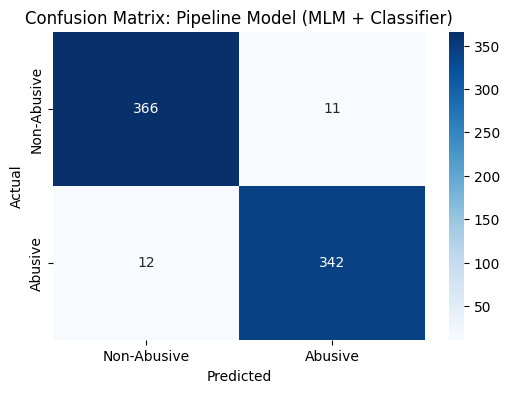

In [ ]:
evaluate_model("/content/tamil_abusive_classifier_final",
               "Pipeline Model (MLM + Classifier)")
